In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [2]:
# 1. Data Preparation
def smiles_to_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits) if mol else None

df = pd.read_csv("tox21.csv")
target = "NR-AR"  # Change to any Tox21 target

# Filter valid samples
X, y = [], []
for _, row in df.iterrows():
    if not pd.isna(row[target]) and row[target] != -1:
        fp = smiles_to_fingerprint(row['smiles'])
        if fp is not None:
            X.append(np.array(fp))
            y.append(int(row[target]))

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerator
[01:07:54] DEPRECATION WARNING: please use MorganGenerat

In [3]:
# 2. Model Architecture
class MLP(nn.Module):
    def __init__(self, input_size=2048):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

In [4]:
# 3. Training Setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [5]:
# 4. Training Loop
train_losses = []
test_aucs = []

for epoch in range(1, 21):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_probs = F.softmax(model(X_test.to(device)), dim=1)[:, 1]
        auc = roc_auc_score(y_test.numpy(), test_probs.cpu().numpy())
        test_aucs.append(auc)
    
    print(f"Epoch {epoch:02d} | Loss: {train_losses[-1]:.4f} | Test AUC: {auc:.4f}")

Epoch 01 | Loss: 0.1795 | Test AUC: 0.7054
Epoch 02 | Loss: 0.1001 | Test AUC: 0.7424
Epoch 03 | Loss: 0.0617 | Test AUC: 0.7343
Epoch 04 | Loss: 0.0397 | Test AUC: 0.7423
Epoch 05 | Loss: 0.0260 | Test AUC: 0.7212
Epoch 06 | Loss: 0.0238 | Test AUC: 0.7251
Epoch 07 | Loss: 0.0179 | Test AUC: 0.7350
Epoch 08 | Loss: 0.0141 | Test AUC: 0.7163
Epoch 09 | Loss: 0.0126 | Test AUC: 0.7191
Epoch 10 | Loss: 0.0097 | Test AUC: 0.7163
Epoch 11 | Loss: 0.0096 | Test AUC: 0.7057
Epoch 12 | Loss: 0.0146 | Test AUC: 0.7108
Epoch 13 | Loss: 0.0089 | Test AUC: 0.7097
Epoch 14 | Loss: 0.0076 | Test AUC: 0.7083
Epoch 15 | Loss: 0.0066 | Test AUC: 0.7082
Epoch 16 | Loss: 0.0070 | Test AUC: 0.7053
Epoch 17 | Loss: 0.0086 | Test AUC: 0.7038
Epoch 18 | Loss: 0.0045 | Test AUC: 0.7100
Epoch 19 | Loss: 0.0111 | Test AUC: 0.7148
Epoch 20 | Loss: 0.0101 | Test AUC: 0.7100


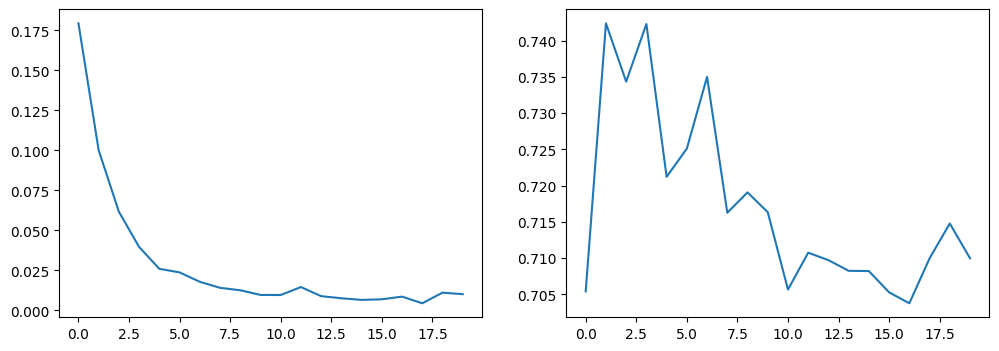

In [6]:
# 5. Save & Visualize
torch.save(model.state_dict(), "mlp_tox21.pt")
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_losses, label="Training Loss")
plt.subplot(122)
plt.plot(test_aucs, label="Test AUC")
plt.savefig("mlp_performance.png")